# SiMCa: Sinkhorn Matrix Factorization with Capacity Constraints

In [6]:
import string
from collections import defaultdict

import torch
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader

from simca import viz
from simca.dataset import ToyDataset, save_dataset, load_dataset
from simca.model import SiMCa
from simca.sinkhorn import SinkhornLoss, sinkhorn, pot_sinkhorn
from simca.utils import assign_with_lap

In [2]:
# global config
sns.set(style="whitegrid", palette="Set2", font_scale=1.3)

## Toy Dataset

In [3]:
# dataset variables
n_centers = 3
n_items = 3
n_users = 1000
distance_weight = 0.3
n_features = 2

# draw dataset
toy = ToyDataset(
    n_centers=n_centers,
    n_items=n_items,
    n_users=n_users,
    n_features=n_features,
    distance_weight=distance_weight
)

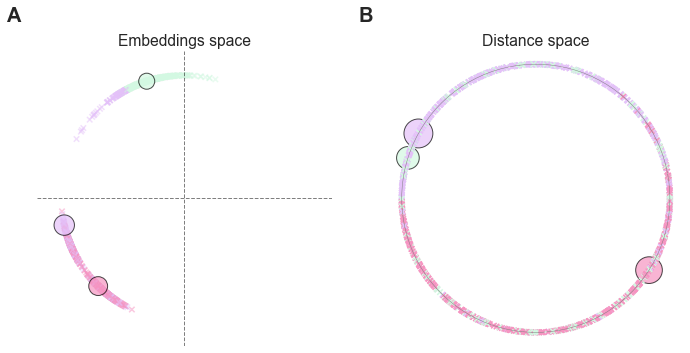

In [4]:
# plot dataset
fig, axs = plt.subplots(figsize=(10, 5), nrows=1, ncols=2)

# Embeddings space
viz.plot_embeddings(
    users_features=torch.from_numpy(toy.users_features),
    items_features=torch.from_numpy(toy.items_features),
    items_capacities=toy.items_capacities,
    y_pred=toy.assigned_item_for_user,
    ax=axs[0]
)

# Distance space
viz.plot_distances(
    np.asarray(list(zip(toy.users_x, toy.users_y))),
    np.asarray(list(zip(toy.items_x, toy.items_y))),
    toy.circle_radius,
    toy.assigned_item_for_user,
    toy.items_capacities,
    axs[1]
)

axs[0].set_title("Embeddings space")
axs[1].set_title("Distance space")

# Annotate with letters
for i in range(2):
    axs[i].text(
        -0.1,
        1.1, 
        string.ascii_uppercase[i],
        transform=axs[i].transAxes, 
        size=20,
        weight="bold"
)

plt.tight_layout()
plt.show()

In [34]:
toy.items_capacities

array([[257, 417, 356]])

In [9]:
# save_dataset(toy, "data/toy_dataset.pkl")
# toy = load_dataset("data/toy_dataset.pkl")

## SiMCa model

In [10]:
sinkhorn_n_iter = 400
sinkhorn_epsilon = .1
n_epochs = 200
learning_rate = 5e-3

In [38]:
model = SiMCa(
    capacities=toy.items_capacities,
    alpha=distance_weight,
    n_users=toy.n_users,
    n_features=toy.n_features,
    user_embeddings=torch.FloatTensor(toy.users_features),
    train_user_embeddings=False
)

a = torch.ones(toy.n_users)
b = torch.FloatTensor(toy.items_capacities).view(-1)

sinkhorn_loss = SinkhornLoss(
    a=a,
    b=b,
    solver=sinkhorn,
    n_iter=sinkhorn_n_iter,
    epsilon=sinkhorn_epsilon
)

optimizer = torch.optim.Adam(
    lr=learning_rate,
    params=model.parameters()
)

In [107]:
def train_model(model, optimizer, sinkhorn_loss, n_epochs, toy, assigned_item_for_user, assign="lap"):
    training_results = []
    
    for epoch_number in range(1, n_epochs+1):
        model.train()
        train_epoch_loss = 0
        optimizer.zero_grad()

        # model out
        M = model(
            toy.users_tensor,
            toy.items_tensor,
            toy.D_tensor
        )

        # loss
        target = torch.nn.functional.one_hot(
            toy.y_true_tensor,
            num_classes=toy.n_items
        )
        loss = sinkhorn_loss(M, target)
        train_epoch_loss += loss.item()
        loss.backward()

        # optimizer
        optimizer.step()

        # Predictions
        model.eval()
        with torch.no_grad():
            P = sinkhorn(
                M, 
                a, 
                b, 
                sinkhorn_loss.epsilon, 
                sinkhorn_loss.solver_options["n_iter"]
            )
        
        if assign == "lap":
            y_pred = assign_with_lap(
                P, 
                toy.items_capacities
            )
        elif assign == "argmax":
            y_pred = torch.argmax(P, axis=1)
        else:
            raise NotImplementedError("Invalid assignment method")
        
        # F1-score evaluation
        f1 = f1_score(
            y_true=assigned_item_for_user, 
            y_pred=y_pred, 
            average="macro"
        )
        
        # Embedding distance evaluation
        average_distance = np.linalg.norm(
            model.item_embeddings.weight.data.numpy() - toy.items_features,
            axis=1
        ).mean()

        if epoch_number % 20 == 0:
            print("Epoch {0}: loss={1:.3f}, f1={2:.3f}, avg_dist={3:.3f}"
                  .format(epoch_number, loss.item(), f1, average_distance))
            
        training_results.append([epoch_number, loss.item(), f1, average_distance])
        
    return training_results

In [40]:
training_results = train_model(model, optimizer, sinkhorn_loss, n_epochs, toy, toy.assigned_item_for_user)
training_results_df = pd.DataFrame(training_results, columns=["epoch", "loss", "F1", "avg_distance"])

Epoch 20: loss=1394.401, f1=0.419, avg_dist=1.063
Epoch 40: loss=848.641, f1=0.563, avg_dist=0.962
Epoch 60: loss=531.158, f1=0.695, avg_dist=0.875
Epoch 80: loss=368.512, f1=0.809, avg_dist=0.804
Epoch 100: loss=283.594, f1=0.897, avg_dist=0.750
Epoch 120: loss=237.282, f1=0.944, avg_dist=0.710
Epoch 140: loss=211.173, f1=0.973, avg_dist=0.682
Epoch 160: loss=195.717, f1=0.989, avg_dist=0.661
Epoch 180: loss=186.006, f1=0.995, avg_dist=0.647
Epoch 200: loss=179.673, f1=1.000, avg_dist=0.637


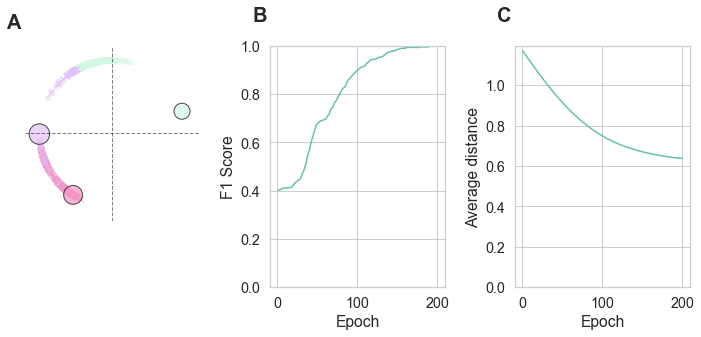

In [51]:
# plot dataset
fig, axs = plt.subplots(figsize=(10, 5), nrows=1, ncols=3)

# Embeddings space
ax = viz.plot_embeddings(
    users_features=model.user_embeddings.weight,
    items_features=model.item_embeddings.weight,
    items_capacities=toy.items_capacities,
    y_pred=toy.assigned_item_for_user,
    ax=axs[0]
)

# F1 score
ax = sns.lineplot(
    data=training_results_df,
    x="epoch",
    y="F1",
    ax=axs[1]
)
ax.set_xlabel("Epoch")
ax.set_ylabel("F1 Score")
ax.set_ylim(0, 1)

# Embedding distance
ax = sns.lineplot(
    data=training_results_df,
    x="epoch",
    y="avg_distance",
    ax=axs[2]
)
ax.set_xlabel("Epoch")
ax.set_ylabel("Average distance")
ax.set_ylim(0, None)

# Annotate with letters
for i in range(3):
    axs[i].set_anchor("N")
    
    axs[i].text(
        -0.1,
        1.1, 
        string.ascii_uppercase[i],
        transform=axs[i].transAxes, 
        size=20,
        weight="bold"
)

plt.tight_layout()
plt.show()

## Experiments

### Training multiple times

In [73]:
n_experiments = 5
experiments_results = pd.DataFrame()

for experiment_index in range(1, n_experiments+1):
    model = SiMCa(
        capacities=toy.items_capacities,
        alpha=distance_weight,
        n_users=toy.n_users,
        n_features=toy.n_features,
        user_embeddings=torch.FloatTensor(toy.users_features),
        train_user_embeddings=False
    )

    a = torch.ones(toy.n_users)
    b = torch.FloatTensor(toy.items_capacities).view(-1)

    sinkhorn_loss = SinkhornLoss(
        a=a,
        b=b,
        solver=sinkhorn,
        n_iter=sinkhorn_n_iter,
        epsilon=sinkhorn_epsilon
    )

    optimizer = torch.optim.Adam(
        lr=learning_rate,
        params=model.parameters()
    )
    
    print("--------- Experiment {0} ---------".format(experiment_index))
    
    training_results = train_model(
        model, 
        optimizer, 
        sinkhorn_loss, 
        n_epochs, 
        toy, 
        toy.assigned_item_for_user
    )
    experiment_results = pd.DataFrame(training_results, columns=["epoch", "loss", "F1", "avg_distance"])
    experiment_results["experiment_index"] = experiment_index
    
    experiments_results = experiments_results.append(experiment_results)

--------- Experiment 1 ---------
Epoch 20: loss=753.650, f1=0.666, avg_dist=1.099
Epoch 40: loss=598.331, f1=0.744, avg_dist=1.043
Epoch 60: loss=505.084, f1=0.764, avg_dist=1.032
Epoch 80: loss=439.541, f1=0.776, avg_dist=1.048
Epoch 100: loss=390.674, f1=0.787, avg_dist=1.071
Epoch 120: loss=353.081, f1=0.794, avg_dist=1.095
Epoch 140: loss=323.639, f1=0.801, avg_dist=1.120
Epoch 160: loss=300.276, f1=0.812, avg_dist=1.143
Epoch 180: loss=281.528, f1=0.823, avg_dist=1.166
Epoch 200: loss=266.328, f1=0.834, avg_dist=1.187
--------- Experiment 2 ---------
Epoch 20: loss=1873.343, f1=0.422, avg_dist=1.343
Epoch 40: loss=1191.880, f1=0.461, avg_dist=1.332
Epoch 60: loss=706.277, f1=0.623, avg_dist=1.317
Epoch 80: loss=441.070, f1=0.736, avg_dist=1.290
Epoch 100: loss=309.843, f1=0.851, avg_dist=1.255
Epoch 120: loss=244.532, f1=0.933, avg_dist=1.224
Epoch 140: loss=210.978, f1=0.965, avg_dist=1.202
Epoch 160: loss=192.638, f1=0.981, avg_dist=1.190
Epoch 180: loss=181.755, f1=0.996, avg_d

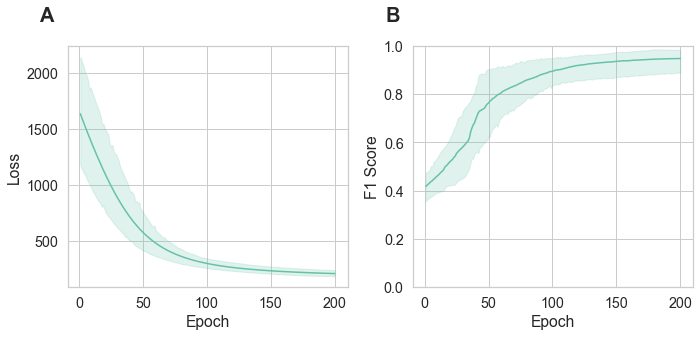

In [74]:
fig, axs = plt.subplots(
    nrows=1, 
    ncols=2, 
    figsize=(10, 5),
    sharex=True
)

# Loss
ax = sns.lineplot(
    data=experiments_results.reset_index(),
    x="epoch",
    y="loss",
    ax=axs[0]
)

ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")

# F1 score
ax = sns.lineplot(
    data=experiments_results.reset_index(),
    x="epoch",
    y="F1",
    ax=axs[1]
)

ax.set_ylim(0, 1)
ax.set_xlabel("Epoch")
ax.set_ylabel("F1 Score")

# Annotate with letters
for i in range(2):
    axs[i].text(
        -0.1,
        1.1, 
        string.ascii_uppercase[i],
        transform=axs[i].transAxes, 
        size=20,
        weight="bold"
)

plt.tight_layout()
plt.show()

### Epsilon influence

In [75]:
n_experiments = 5
experiments_results = pd.DataFrame()

for epsilon in [0.05, 0.1, 0.25, 0.5, 0.75, 1]:
    print("--------- Epsilon {0} ---------".format(epsilon))
    
    for experiment_index in range(1, n_experiments+1):
        model = SiMCa(
            capacities=toy.items_capacities,
            alpha=distance_weight,
            n_users=toy.n_users,
            n_features=toy.n_features,
            user_embeddings=torch.FloatTensor(toy.users_features),
            train_user_embeddings=False
        )

        a = torch.ones(toy.n_users)
        b = torch.FloatTensor(toy.items_capacities).view(-1)

        sinkhorn_loss = SinkhornLoss(
            a=a,
            b=b,
            solver=sinkhorn,
            n_iter=sinkhorn_n_iter,
            epsilon=epsilon
        )

        optimizer = torch.optim.Adam(
            lr=learning_rate,
            params=model.parameters()
        )

        print("--------- Experiment {0} ---------".format(experiment_index))

        training_results = train_model(model, optimizer, sinkhorn_loss, n_epochs, toy, toy.assigned_item_for_user)
        experiment_results = pd.DataFrame(training_results, columns=["epoch", "loss", "F1", "avg_distance"])
        experiment_results["experiment_index"] = experiment_index
        experiment_results["epsilon"] = str(epsilon)

        experiments_results = experiments_results.append(experiment_results)

--------- Epsilon 0.05 ---------
--------- Experiment 1 ---------
Epoch 20: loss=1150.575, f1=0.718, avg_dist=0.889
Epoch 40: loss=750.862, f1=0.784, avg_dist=0.859
Epoch 60: loss=435.482, f1=0.811, avg_dist=0.849
Epoch 80: loss=301.580, f1=0.878, avg_dist=0.848
Epoch 100: loss=256.142, f1=0.925, avg_dist=0.851
Epoch 120: loss=225.620, f1=0.942, avg_dist=0.858
Epoch 140: loss=203.203, f1=0.949, avg_dist=0.870
Epoch 160: loss=187.285, f1=0.954, avg_dist=0.887
Epoch 180: loss=176.137, f1=0.957, avg_dist=0.910
Epoch 200: loss=168.345, f1=0.958, avg_dist=0.936
--------- Experiment 2 ---------
Epoch 20: loss=8246.757, f1=0.395, avg_dist=1.743
Epoch 40: loss=6744.405, f1=0.395, avg_dist=1.637
Epoch 60: loss=5242.886, f1=0.396, avg_dist=1.535
Epoch 80: loss=3742.397, f1=0.396, avg_dist=1.438
Epoch 100: loss=2245.959, f1=0.396, avg_dist=1.346
Epoch 120: loss=982.740, f1=0.523, avg_dist=1.264
Epoch 140: loss=465.260, f1=0.786, avg_dist=1.212
Epoch 160: loss=313.901, f1=0.882, avg_dist=1.189
Epo

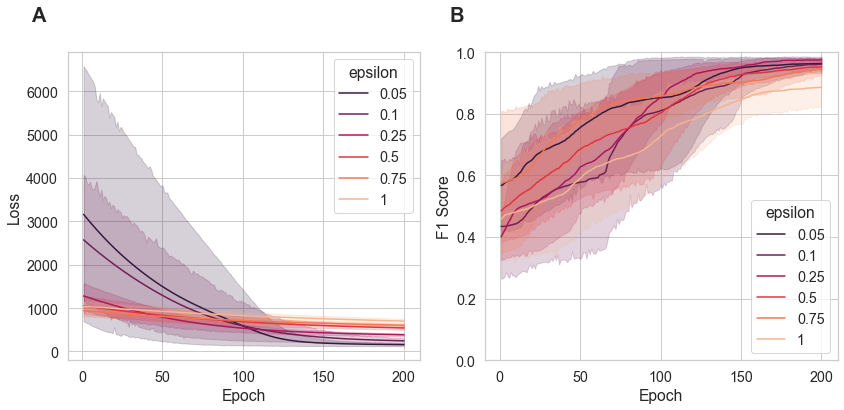

In [76]:
fig, axs = plt.subplots(
    nrows=1, 
    ncols=2, 
    figsize=(12, 6),
    sharex=True
)

# Loss
ax = sns.lineplot(
    data=experiments_results.reset_index(),
    x="epoch",
    y="loss",
    hue="epsilon",
    ax=axs[0],
    palette=sns.color_palette("rocket", n_colors=6)
)

ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")

# F1 score
ax = sns.lineplot(
    data=experiments_results.reset_index(),
    x="epoch",
    y="F1",
    hue="epsilon",
    ax=axs[1],
    palette=sns.color_palette("rocket", n_colors=6)
)

ax.set_ylim(0, 1)
ax.set_xlabel("Epoch")
ax.set_ylabel("F1 Score")

# Annotate with letters
for i in range(2):
    axs[i].text(
        -0.1,
        1.1, 
        string.ascii_uppercase[i],
        transform=axs[i].transAxes, 
        size=20,
        weight="bold"
    )

plt.tight_layout()
plt.show()

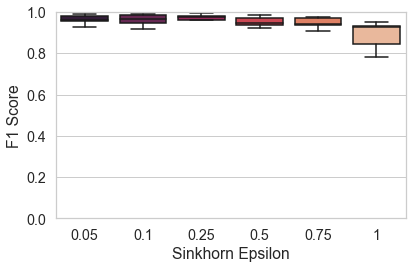

In [77]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))

# F1 score boxplot
ax = sns.boxplot(
    data=experiments_results.loc[experiments_results["epoch"] == 200].reset_index(),
    x="epsilon",
    y="F1", 
    ax=ax,
    palette=sns.color_palette("rocket", n_colors=6)
)

ax.set_xlabel("Sinkhorn Epsilon")
ax.set_ylabel("F1 Score")
ax.set_ylim(0, 1)

plt.tight_layout()
plt.show()

### Noise influence

#### Gaussian noise on users features

In [100]:
n_experiments = 5
experiments_results_1 = pd.DataFrame()

for noise_ratio in [0, 0.2, 0.4, 0.6, 0.8, 1]:
    print("--------- Noise {0} ---------".format(noise_ratio))
    
    noised_users_features = toy.add_gaussian_noise_to_users_features(ratio=noise_ratio)
    
    for experiment_index in range(1, n_experiments+1):
        model = SiMCa(
            capacities=toy.items_capacities,
            alpha=distance_weight,
            n_users=toy.n_users,
            n_features=toy.n_features,
            user_embeddings=torch.FloatTensor(noised_users_features),
            train_user_embeddings=False
        )

        a = torch.ones(toy.n_users)
        b = torch.FloatTensor(toy.items_capacities).view(-1)

        sinkhorn_loss = SinkhornLoss(
            a=a,
            b=b,
            solver=sinkhorn,
            n_iter=sinkhorn_n_iter,
            epsilon=sinkhorn_epsilon
        )

        optimizer = torch.optim.Adam(
            lr=learning_rate,
            params=model.parameters()
        )

        print("--------- Experiment {0} ---------".format(experiment_index))

        training_results = train_model(model, optimizer, sinkhorn_loss, n_epochs, toy, toy.assigned_item_for_user)
        experiment_results = pd.DataFrame(training_results, columns=["epoch", "loss", "F1", "avg_distance"])
        experiment_results["experiment_index"] = experiment_index
        experiment_results["noise"] = str(noise_ratio)

        experiments_results_1 = experiments_results_1.append(experiment_results)

--------- Noise 0 ---------
--------- Experiment 1 ---------
Epoch 20: loss=229.348, f1=0.970, avg_dist=0.832
Epoch 40: loss=210.500, f1=0.976, avg_dist=0.867
Epoch 60: loss=205.103, f1=0.976, avg_dist=0.927
Epoch 80: loss=202.872, f1=0.976, avg_dist=0.998
Epoch 100: loss=201.003, f1=0.976, avg_dist=1.078
Epoch 120: loss=199.158, f1=0.976, avg_dist=1.164
Epoch 140: loss=197.374, f1=0.978, avg_dist=1.254
Epoch 160: loss=195.667, f1=0.978, avg_dist=1.349
Epoch 180: loss=194.053, f1=0.980, avg_dist=1.447
Epoch 200: loss=192.531, f1=0.982, avg_dist=1.547
Epoch 220: loss=191.094, f1=0.982, avg_dist=1.649
Epoch 240: loss=189.732, f1=0.980, avg_dist=1.753
Epoch 260: loss=188.438, f1=0.980, avg_dist=1.858
Epoch 280: loss=187.202, f1=0.980, avg_dist=1.964
Epoch 300: loss=186.019, f1=0.980, avg_dist=2.071
Epoch 320: loss=184.884, f1=0.976, avg_dist=2.179
Epoch 340: loss=183.789, f1=0.976, avg_dist=2.287
Epoch 360: loss=182.734, f1=0.976, avg_dist=2.395
Epoch 380: loss=181.713, f1=0.973, avg_dist

#### Permutation noise

In [108]:
n_experiments = 5
experiments_results_2 = pd.DataFrame()

for noise_ratio in [0, 0.2, 0.4, 0.6, 0.8, 1]:
    print("--------- Noise {0} ---------".format(noise_ratio))
    
    noised_assigned_item_for_user = toy.add_random_permutations(
        n_permutations=int(toy.n_users*noise_ratio)
    )
    
    for experiment_index in range(1, n_experiments+1):
        model = SiMCa(
            capacities=toy.items_capacities,
            alpha=distance_weight,
            n_users=toy.n_users,
            n_features=toy.n_features,
            user_embeddings=torch.FloatTensor(toy.users_features),
            train_user_embeddings=False
        )

        a = torch.ones(toy.n_users)
        b = torch.FloatTensor(toy.items_capacities).view(-1)

        sinkhorn_loss = SinkhornLoss(
            a=a,
            b=b,
            solver=sinkhorn,
            n_iter=sinkhorn_n_iter,
            epsilon=sinkhorn_epsilon
        )

        optimizer = torch.optim.Adam(
            lr=learning_rate,
            params=model.parameters()
        )

        print("--------- Experiment {0} ---------".format(experiment_index))

        training_results = train_model(model, optimizer, sinkhorn_loss, n_epochs, toy, noised_assigned_item_for_user)
        experiment_results = pd.DataFrame(training_results, columns=["epoch", "loss", "F1", "avg_distance"])
        experiment_results["experiment_index"] = experiment_index
        experiment_results["noise"] = str(noise_ratio)

        experiments_results_2 = experiments_results_2.append(experiment_results)

--------- Noise 0 ---------
--------- Experiment 1 ---------
Epoch 20: loss=976.361, f1=0.427, avg_dist=0.765
Epoch 40: loss=519.899, f1=0.880, avg_dist=0.654
Epoch 60: loss=340.006, f1=0.956, avg_dist=0.578
Epoch 80: loss=277.605, f1=0.962, avg_dist=0.533
Epoch 100: loss=249.661, f1=0.964, avg_dist=0.505
Epoch 120: loss=233.696, f1=0.968, avg_dist=0.485
Epoch 140: loss=223.163, f1=0.968, avg_dist=0.471
Epoch 160: loss=215.643, f1=0.970, avg_dist=0.461
Epoch 180: loss=210.023, f1=0.974, avg_dist=0.453
Epoch 200: loss=205.704, f1=0.974, avg_dist=0.448
Epoch 220: loss=202.323, f1=0.974, avg_dist=0.445
Epoch 240: loss=199.643, f1=0.976, avg_dist=0.444
Epoch 260: loss=197.500, f1=0.976, avg_dist=0.446
Epoch 280: loss=195.776, f1=0.978, avg_dist=0.449
Epoch 300: loss=194.386, f1=0.978, avg_dist=0.456
Epoch 320: loss=193.262, f1=0.978, avg_dist=0.466
Epoch 340: loss=192.353, f1=0.978, avg_dist=0.479
Epoch 360: loss=191.620, f1=0.978, avg_dist=0.494
Epoch 380: loss=191.030, f1=0.978, avg_dist

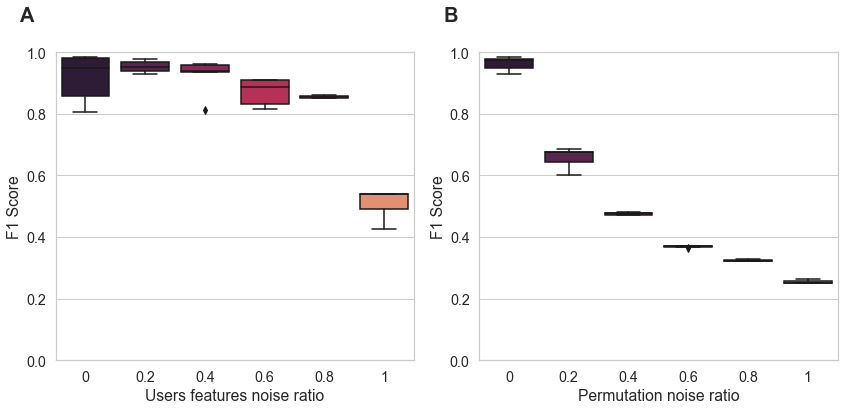

In [109]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Users features noise
ax = sns.boxplot(
    data=experiments_results_1.loc[experiments_results_1["epoch"] == 200].reset_index(),
    x="noise",
    y="F1", 
    ax=axs[0],
    palette=sns.color_palette("rocket", n_colors=7)
)

ax.set_xlabel("Users features noise ratio")
ax.set_ylabel("F1 Score")
ax.set_ylim(0, 1)

# Permutation noise
ax = sns.boxplot(
    data=experiments_results_2.loc[experiments_results_2["epoch"] == 200].reset_index(),
    x="noise",
    y="F1", 
    ax=axs[1],
    palette=sns.color_palette("rocket", n_colors=7)
)

ax.set_xlabel("Permutation noise ratio")
ax.set_ylabel("F1 Score")
ax.set_ylim(0, 1)

# Annotate with letters
for i in range(2):
    axs[i].text(
        -0.1,
        1.1, 
        string.ascii_uppercase[i],
        transform=axs[i].transAxes, 
        size=20,
        weight="bold"
    )

plt.tight_layout()
plt.show()

### Learning users and items embeddings jointly

In [67]:
model = SiMCa(
    capacities=toy.items_capacities,
    alpha=distance_weight,
    n_users=toy.n_users,
    n_features=toy.n_features,
    user_embeddings=None,
    train_user_embeddings=True
)

optimizer = torch.optim.Adam(
    lr=5e-3,
    params=model.parameters()
)

In [68]:
a = torch.ones(toy.n_users)
b = torch.FloatTensor(toy.items_capacities).view(-1)

sinkhorn_loss = SinkhornLoss(
    a=a,
    b=b,
    solver=sinkhorn,
    n_iter=sinkhorn_n_iter,
    epsilon=sinkhorn_epsilon
)

training_results = train_model(
    model, 
    optimizer, 
    sinkhorn_loss, 
    n_epochs, 
    toy, 
    toy.assigned_item_for_user, 
    assign="lap"
)
training_results_df = pd.DataFrame(
    training_results,
    columns=["epoch", "loss", "F1", "avg_distance"]
)

Epoch 20: loss=1926.013, f1=0.506, avg_dist=1.591
Epoch 40: loss=1269.464, f1=0.604, avg_dist=1.528
Epoch 60: loss=870.309, f1=0.697, avg_dist=1.495
Epoch 80: loss=624.495, f1=0.781, avg_dist=1.479
Epoch 100: loss=465.688, f1=0.837, avg_dist=1.477
Epoch 120: loss=357.387, f1=0.879, avg_dist=1.484
Epoch 140: loss=280.265, f1=0.905, avg_dist=1.496
Epoch 160: loss=223.719, f1=0.930, avg_dist=1.513
Epoch 180: loss=181.500, f1=0.948, avg_dist=1.532
Epoch 200: loss=149.565, f1=0.961, avg_dist=1.553


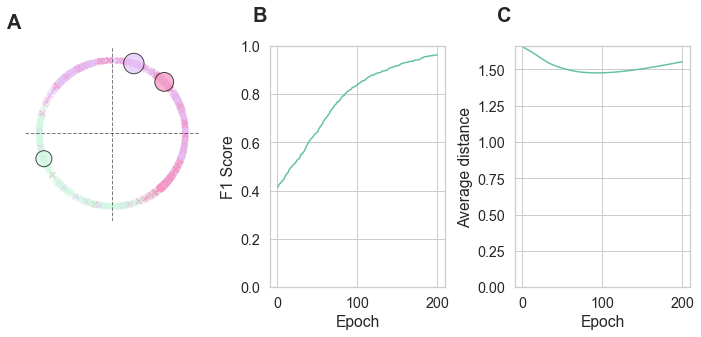

In [70]:
# plot dataset
fig, axs = plt.subplots(figsize=(10, 5), nrows=1, ncols=3)

# Embeddings space
ax = viz.plot_embeddings(
    users_features=model.user_embeddings.weight,
    items_features=model.item_embeddings.weight,
    items_capacities=toy.items_capacities,
    y_pred=toy.assigned_item_for_user,
    ax=axs[0]
)

# F1 score
ax = sns.lineplot(
    data=training_results_df,
    x="epoch",
    y="F1",
    ax=axs[1]
)
ax.set_xlabel("Epoch")
ax.set_ylabel("F1 Score")
ax.set_ylim(0, 1)

# Embedding distance
ax = sns.lineplot(
    data=training_results_df,
    x="epoch",
    y="avg_distance",
    ax=axs[2]
)
ax.set_xlabel("Epoch")
ax.set_ylabel("Average distance")
ax.set_ylim(0, None)

# Annotate with letters
for i in range(3):
    axs[i].set_anchor("N")
    
    axs[i].text(
        -0.1,
        1.1, 
        string.ascii_uppercase[i],
        transform=axs[i].transAxes, 
        size=20,
        weight="bold"
)

plt.tight_layout()
plt.show()